In [1]:
%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np

#sys.path.append('../')
from pyqsofit import PyQSOFit
from astropy.io import fits,ascii
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings
import importlib
from astropy import constants
from astropy import units as u
ckm=constants.c.to(u.km/u.s).value

importlib.reload(PyQSOFit)
#importlib.reload(pyqsofit)

warnings.filterwarnings("ignore")
import re
#QSOFit.set_mpl_style()
sys.path.append('/disk/bifrost/yuanze/multiAGN/scripts')
import line_fit




# Step1: read spectrum


## Start fitting

In [35]:
# Prepare data

KBSSpath="/disk/bifrost/yuanze/KBSS"
#cubename="Q1217"
#
tlist=["Q0100-BX160"]#["Q0207-D9","Q0256-c31","Q1549-GNB4950",]#,"Q2343-C28"

for target in tlist:
    cubename=target.split("-")[0]#"Q0100"
    sourcename=target.split("-")[1]#
    psname=sourcename#"MD77"
    cubename_infile=cubename
    
    #redshift=2.6347
    #RA=184.91584
    #DEC=49.66657


    #qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
    qsos = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")

    sentry=qsos[(qsos["Name"]==sourcename) & (qsos["Field"]==cubename)]
    #cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if sentry["zneb"]>0:
        redshift=sentry["zneb"].value[0]
    elif sentry["zabs"]>0:
        redshift=sentry["zabs"].value[0]
    else:
        redshift=sentry["zlya"].value[0]
    RA = sentry["RA"].value[0]
    Dec = sentry["Decl"].value[0]
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]

    datapath=KBSSpath+"/"+cubename+"/"+sourcename
    subdapath=KBSSpath+"/"+cubename+"/"+psname

    path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')
    instru="lris"
    all_band=["H"]
    channel="_blue"



    # Requried
    if instru == "jwst":
        channel = ""
        matches=[]
        pattern = re.compile(r'^.*\.{}.*\.fits$'.format(sourcename), re.IGNORECASE)
        folder=subdapath+"/jwst"
        for fname in os.listdir(folder):
            if pattern.match(fname):
                matches.append(fname)
        print("reading",folder+"/"+matches[0])
        hdu = fits.open(folder+"/"+matches[0])#datapath+f"/{instru}/GWS_tot.300004.CC50.fits")#SSA22.10004.AGN_2223.flam.fits")#tot.4096.MD90.v1.fits"
        lam = 10**(hdu[0].header["CRVAL1"]+ (np.arange(hdu[0].data.shape[1])+1-hdu[0].header["CRPIX1"])*hdu[0].header["CD1_1"])  # OBS wavelength [A]
        if ("BUNIT" in hdu[0].header) and ("Jy" in hdu[0].header["BUNIT"]):
            print(hdu[0].header["BUNIT"],"; Fnu detected: converting to Flam")
            efactor=2.998e-8/lam**2.0*1e16
        else:
            print("using 1e-20 flam")
            efactor=1e20

        flux = hdu[0].data[0,:]*efactor #1e-20 [cgs] flam
        err = hdu[0].data[1,:]*efactor  # 1 sigma error
        path_out = os.path.join(datapath, '{}'.format(instru.split("_")[0]))
    elif instru == "kcwi":
        if channel == "_red":
            postfix="-red"
        else:
            postfix=""
        hdu = fits.open(KBSSpath+f"/faint_qsos/result/{cubename}-{psname}_kcwi_oned{postfix}.fits")
        flux = hdu['SPEC'].data*1e4 #1e-20 [cgs] flam
        hdr=hdu[1].header
        lam = ((np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1'])  # OBS wavelength [A]
        err = np.sqrt(hdu['VARIANCE'].data)*1e4  # 1 sigma error
        path_out = os.path.join(datapath, '{}_1D'.format(instru.split("_")[0]))
        os.makedirs(path_out, exist_ok = True) 
    elif instru == "mosfire":
        channel = ""
        lam=None
        path_out = os.path.join(datapath, '{}/onedspec'.format(instru.split("_")[0]))
        for band in all_band:
            matches=[]
            pattern = re.compile(r'^.*\_{}.*\_1d.fits$'.format(band), re.IGNORECASE)
            folder=subdapath+"/mosfire/onedspec"
            for fname in os.listdir(folder):
                if pattern.match(fname):
                    matches.append(fname)
            if matches:
                print("Matched files:")
                for m in matches:
                    print("  ", m)
            else:
                print(f"No {band}-band data, skipping...")
                continue
            hdu = fits.open(folder+"/"+matches[0])
            lam_temp = hdu[0].header["CRVAL1"] + (np.arange(hdu[0].data.shape[1])+1-hdu[0].header["CRPIX1"])*hdu[0].header["CD1_1"]
            flux_temp = hdu[0].data[0]*1e2 #1e-19 [cgs] flam 
            err_temp = hdu[0].data[1]*1e2
            if lam is None:
                lam=lam_temp
                flux=flux_temp
                err=err_temp
            else:
                lam = np.append(lam,lam_temp)
                flux=np.append(flux,flux_temp)
                err=np.append(err,err_temp)
    elif instru == "lris":
        channel = ""
        path_out = os.path.join(datapath, '{}'.format(instru.split("_")[0]))
        matches=[]
        pattern = re.compile(r'^{}.*.fits$'.format(cubename), re.IGNORECASE)
        folder=subdapath+"/lris/spec"

        for fname in os.listdir(folder):
            if pattern.match(fname):
                matches.append(fname)
        if matches:
            print("Matched files:")
            for m in matches:
                print("  ", m)
        else:
            print(f"No lris data, skipping...")
        print("using",folder+"/"+matches[0])
        hdu = fits.open(folder+"/"+matches[0])
        #if "Hz" in hdu[0].header["BUNIT"]:
        fnu2flam=True
        #print(hdu[0].header["BUNIT"],"; Fnu detected: converting to Flam")
        #else:
        #    fnu2flam=False
        lam = hdu[0].header["CRVAL1"] + (np.arange(hdu[0].data.shape[0])+1-hdu[0].header["CRPIX1"])*hdu[0].header["CD1_1"]
        if fnu2flam:
            efactor=2.998e18/lam**2.0#*1e-10
        else:
            efactor=1
        flux = efactor*hdu[0].data #1e-17 [cgs] flam 
        print("median flux is:",np.median(flux))
        flux /=np.median(flux)
        err = np.ones(hdu[0].data.shape)
    #hdu.close()

    #continuum
    #cont=np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_ppxfmodel_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))*1e20 # to 1e-20
    #contwave=np.loadtxt(os.path.join(path_out, "wave_ln_binned.txt"))
    #continterp=np.interp(lam,contwave,cont)
    #flux=(data[:,1]-continterp)*1e-3
    create_parfile(path_ex, instru,channel)

    if instru =="kcwi" and channel == "blue":
        goodpixind=((lam>3500) &(lam<5579))
    elif instru == "kcwi" and channel == "red":
        goodpixind=((lam>5680) &(lam<8860))
    else:
        goodpixind=lam>0#~((lam<6050) &(lam>5779))

    q_mle = PyQSOFit.QSOFit(lam[goodpixind], flux[goodpixind], err[goodpixind], redshift, ra=RA, dec=Dec, path=path_ex)#plateid=plateid, mjd=mjd, fiberid=fiberid,ra=ra, dec=dec,

    # Double check the installation path with the PCA / Fe template files
    #print('install path:', q_mle.install_path)

    # Change it if you installed them somewhere else
    #q_mle.install_path = '...'

    start = timeit.default_timer()
    # Do the fitting
    #continterp=np.interp(q_mle.wave,contwave,cont)

    q_mle.Fit(#num_abs_line=1,
              #Cf=[0.8,0.0,1.0],
              #nline=[1], #the number of absorption lines in each abs_ncomp velocity component.
              #abs_ncomp=1, # number of indenpendent velocity components
              external_cont=None,
              name=f"{cubename}-{psname}",  # customize the name of given targets. Default: plate-mjd-fiber
              # prepocessing parameters
              nsmooth=None,  # do n-pixel smoothing to the raw input flux and err spectra
              and_mask=False,  # delete the and masked pixels
              or_mask=False,  # delete the or masked pixels
              reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
              deredden=True,  # correct the Galactic extinction
              wave_range=None,  # trim input wavelength
              wave_mask=None,  # 2-D array, mask the given range(s)

              # host decomposition parameters
              decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
              host_prior=False, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
              host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

              host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
              decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
              qso_type='CZBIN1', # PCA template name for quasar
              npca_qso=10, # numebr of quasar templates
              host_type='PCA', # template name for galaxy
              npca_gal=5, # number of galaxy templates

              # continuum model fit parameters
              do_continumm=True, # ignore the whole continuum fitting process with MCMC
              Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
              poly=False,  # If True, fit continuum with the polynomial component to account for the dust reddening
              BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
              initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
              rej_abs_conti=True,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
              n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

              # emission line fit parameters
              linefit=True,  # If True, the emission line will be fitted
              rej_abs_line=True,
              # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

              # fitting method selection
              MC=False,
              # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
              MCMC=False,
              # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
              nsamp=2000,
              # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

              # advanced fitting parameters
              param_file_name='spec_1D_par_{}{}.fits'.format(instru,channel),  # Name of the qso fitting parameter FITS file.
              nburn=100,  # The number of burn-in samples to run MCMC chain
              nthin=10,  # To set the MCMC chain returns every n samples
              epsilon_jitter=0.,
              # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

              # customize the results
              save_result=False,  # If True, all the fitting results will be saved to a fits file
              save_fits_name=f"{cubename}-{psname}_{instru}_pyqsofit",  # The output name of the result fits
              save_fits_path=path_out,  # The output path of the result fits
              plot_fig=True,  # If True, the fitting results will be plotted
              save_fig=True,  # If True, the figure will be saved
              plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True

              # debugging mode
              verbose=True,  # turn on (True) or off (False) debugging output

              # sublevel parameters for figure plot and emcee
              kwargs_plot={
                  'save_fig_path': path_out,  # The output path of the figure
                  'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
              },
              kwargs_conti_emcee={},
              kwargs_line_emcee={})

    end = timeit.default_timer()

    print(f'Fitting finished in {np.round(end - start, 1)}s')

Matched files:
   q0100_7.b.BX160.msdfc_v.fits
   Q0100-BX160_pyqsofit.fits
using /disk/bifrost/yuanze/KBSS/Q0100/BX160/lris/spec/q0100_7.b.BX160.msdfc_v.fits
median flux is: 3.3782320069735405e-19
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.1      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Blamer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_op_norm          0        0    1e+10     None    False     None     None
Fe_op_shift         0    -0.01     0.01     None    False     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_uv_norm          0        0    1e+10     None    False     None     None
Fe_uv_shift         0    -0.01     0.01     None    False     None     None
PL_norm            18        0    1e+10 

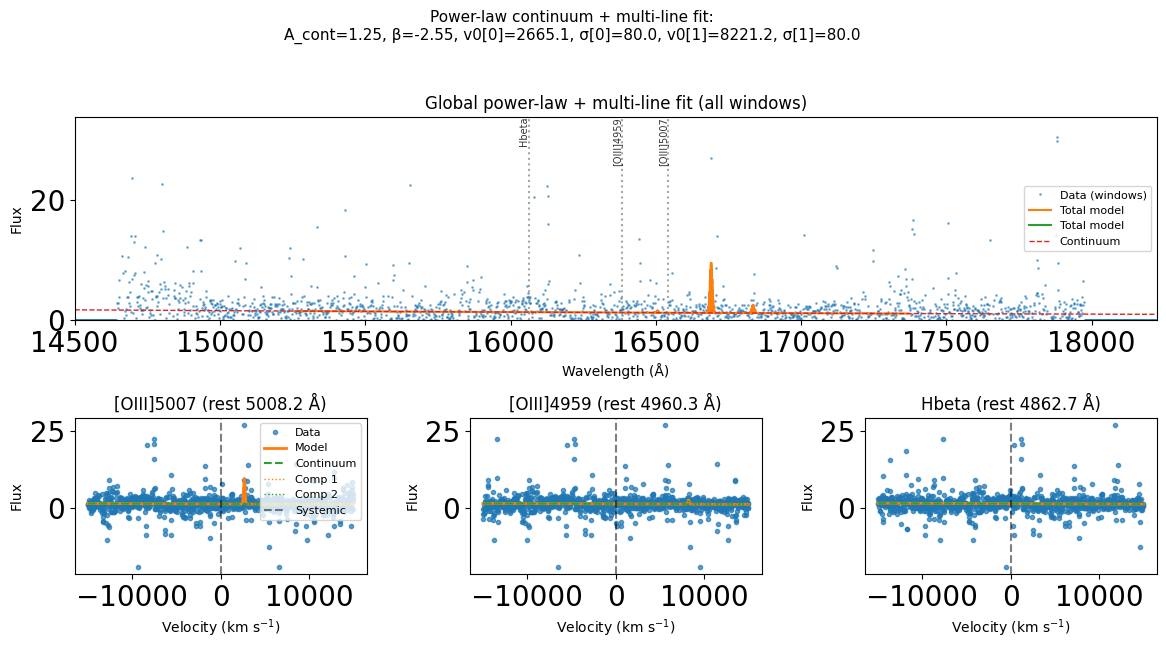

In [19]:
importlib.reload(line_fit)
#lam0_rest = 6564.63

# 1) Fit line 
line_list = {
    "Halpha": 6564.63,
   # "NII6549": 6549.85,
    #"NII6585": 6585.28,
    "[OIII]5007": 5008.24,
    "[OIII]4959": 4960.30,
    #"[OII]3727": 3727.29,
    "Hbeta": 4862.68,
}

fit_res = line_fit.fit_emission_lines_powerlaw(
    lam,
    flux,
    line_list=line_list,
    z_sys=redshift,
    n_kin=2,
    v_window=15000.0,
    saveplot_path=path_out+f"/fitted_spec_{band}.pdf",
    make_plot=True,
)



In [14]:
filters_wl={}
curve={}
cfilter="/disk/bifrost/yuanze/cigale-v2022.1/database_builder/filters/gazpar"
gfilter="/disk/bifrost/yuanze/cigale-v2022.1/database_builder/filters"
myfilter="/disk/bifrost/yuanze/cigale-v2022.1"
## Generate filter curves:
filterlist=np.loadtxt("/disk/bifrost/yuanze/KBSS/cigale_data/filter_list_type1.txt",dtype="str")
for filter in filterlist:
    ftype="photon"
    if re.findall(r"^mosfire.+",filter):
        match=re.findall(r"^mosfire.+",filter)[0]
        curve[filter]=np.genfromtxt(myfilter+"/mosfire_filters/"+match+".dat")
    elif re.findall(r".+mosfire.+",filter):
        match=re.findall(r".+mosfire.+",filter)[0]
        curve[filter]=np.genfromtxt(myfilter+"/my_filters/"+match)
        ftype="energy"
    elif re.findall(r"cfht.megacam.+",filter):
        match=re.findall(r"cfht.megacam.+",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/cfht/megacam/"+re.findall(r"\w+$",match)[0]+".pb")
    elif re.findall(r"cfht.wircam.+",filter):
        match=re.findall(r"cfht.wircam.+",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/cfht/wircam/"+re.findall(r"\w+$",match)[0]+".pb")
    elif re.findall(r"hst.wfc3.(.+)",filter):
        match=re.findall(r"hst.wfc3.(.+)",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/hst/wfc3/"+re.findall(r"F.+",match)[0]+".pb")
    elif re.findall(r"hst.wfc.(.+)",filter):
        match=re.findall(r"hst.wfc.(.+)",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/hst/wfc/"+re.findall(r"F.+",match)[0]+".pb")
    elif re.findall(r"spitzer.+",filter):
        match=re.findall(r"spitzer.+",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/spitzer/"+re.findall(r"irac|mips",match)[0]+"/"+re.findall(r"ch.|24|70|160",match)[0]+".pb")
    elif re.findall(r"subaru.suprime.+",filter):
        match=re.findall(r"subaru.suprime.+",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/subaru/suprime/"+re.findall(r"\w+$",match)[0]+".pb")
    elif re.findall(r"subaru.hsc.+",filter):
        match=re.findall(r"subaru.hsc.+",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/subaru/hsc/"+re.findall(r"\w+$",match)[0]+".pb")
    elif re.findall(r".+lris$",filter):
        match=re.findall(r".+lris",filter)[0]
        curve[filter]=np.genfromtxt(myfilter+"/lris_filters/"+match+".dat")
    elif re.findall(r"WISE.+",filter):
        match=re.findall(r"WISE.+",filter)[0]
        curve[filter]=np.genfromtxt(gfilter+"/"+match+".dat")
    elif re.findall(r"sdss.+",filter):
        match=re.findall(r"sdss.(.+)",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/sdss/"+match+".pb")
    elif re.findall(r"2mass.+",filter):
        match=re.findall(r"2mass.(.+)",filter)[0]
        curve[filter]=np.genfromtxt(cfilter+"/2mass/"+match+".pb")
    elif re.findall(r"jwst.nircam.+",filter):
        match=re.findall(r"jwst.nircam.(.+)",filter)[0]
        curve[filter]=np.genfromtxt(gfilter+"/jwst/nircam/"+match+".dat")
    elif re.findall(r"jwst.miri.+",filter):
        match=re.findall(r"jwst.miri.(.+)",filter)[0]
        curve[filter]=np.genfromtxt(gfilter+"/jwst/miri/"+match+".dat")  
    
    #Assuming all filters have been taken care of
    wl=curve[filter][:,0]
    if ftype == "photon":
        tr=curve[filter][:,1]*wl
    else:
        tr=curve[filter][:,1]
    # pivot wavelength of filters

    filters_wl[filter]=np.sqrt(np.trapz(tr, wl) / np.trapz(tr / wl**2, wl))

In [16]:
instrument_to_correct="wfc3"
band_to_correct="f160w"
filters={}
for match in ["hst.wfc3.F160W"]:#[f"{instrument_to_correct}_{band_to_correct}"]:
    lam_f = curve[match][:,0]
    T_f = curve[match][:,1]
    filters[match]= (lam_f,T_f)

In [17]:
importlib.reload(line_fit)
band_results = line_fit.compute_line_and_continuum_in_filters_powerlaw(
    fit_res,
    lam,
    filters,
    make_plots=True,
    saveplot_path=path_out+"/line_in_filter.pdf",
    per_line_in_plot=True
)

for fname, res in band_results.items():
    print(
        f"{fname}: line_fraction = {res['line_fraction']:.3f}, "
        f"line_band = {res['line_band']:.3e}, cont_band = {res['cont_band']:.3e}"
    )
line_fit.save_band_results_powerlaw_csv(band_results,datapath+f"/line_corrections_{instrument_to_correct}_{band_to_correct}.csv")

NameError: name 'fit_res' is not defined

In [18]:
for fname, res in band_results.items():
    print(
        f"{fname}: line_fraction = {res['line_fraction']:.3f}, "
        f"line_band = {res['line_band']:.3e}, total_band = {res['total_band']:.3e}"
    )

NameError: name 'band_results' is not defined

## Fitting parameter setup

In [34]:

# create FITS file containing fitting parameter setup 

def create_parfile(path_ex, instru,channel):
    hdr0 = fits.Header()
    hdr0['Author'] = 'Yuanze Ding'
    primary_hdu = fits.PrimaryHDU(header=hdr0)

    """
    In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
    """

    line_priors = np.rec.array([
     #   (5889.950, 'Ha', 2800, 6800, 'NaI5890', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 4, 0, 1, 0.2, 1),
     #   (5895.924, 'Ha', 2800, 6800, 'NaI5896', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 4, 0, 1, 0.1, 1),
     #   (5889.950, 'Ha', 2800, 6800, 'NaI5890w', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 5, 0, 2, 0.2, 1),
     #   (5895.924, 'Ha', 2800, 6800, 'NaI5896w', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 5, 0, 2, 0.1, 1),
        #(6564.61, 'Ha', 2800, 6800, 'Ha_br',     1, 0.0, 0.0, 1e10, 4e-3, 4e-5, 0.01, -0.015, 0.015, 0, 0, 0, 0.05, 1),
       # (6549.85, 'Ha', 6400, 6800, 'NII6549_br', 1, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, -0.015, 0.015, 2, 0, 0, 0.05, 1),
       # (6585.28, 'Ha', 6400, 6800, 'NII6585_br', 1, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, -0.015, 0.015, 2, 0, 0, 0.05, 1),
       (6564.61, 'Ha', 2800, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 2e-4, 2.3e-7, 0.00169, -5e-3, 5e-3, 2, 2, 0, 0.002, 1),
       # (6549.85, 'Ha', 2800, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 2e-4, 2.3e-7, 0.00169, -5e-3, 5e-3, 2, 2, 0, 0.001, 1),
       # (6585.28, 'Ha', 2800, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 2e-4, 2.3e-7, 0.00169, -5e-3, 5e-3, 2, 2, 0, 0.003, 1),
        #(6718.29, 'Ha', 2800, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),
        #(6732.67, 'Ha', 2800, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),
        #(5875.621, 'Ha', 2800, 6800, 'HeI5876', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),




    #    (8498.02, 'Ha', 6400, 6800, 'CaII8498', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
    #    (8542.09, 'Ha', 6400, 6800, 'CaII8542', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
    #    (8662.14, 'Ha', 6400, 6800, 'CaII8662', 1, 0.0,  -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),

       # (6564.61, 'Ha', 2800, 6800, 'Ha_naw',  1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7,  0.00169, -0.01, 0.01, 3, 3, 0, 0.002, 1),
    #   (6549.85, 'Ha', 2800, 6800, 'NII6549w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.001, 1),
    #    (6585.28, 'Ha', 2800, 6800, 'NII6585w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.003, 1),
    #    (6718.29, 'Ha', 2800, 6800, 'SII6718w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.001, 1),
    #    (6732.67, 'Ha', 2800, 6800, 'SII6732w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.001, 1),
      #  (4341.69, 'Ha', 2800, 6800, 'Hg_br', 1, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,    -0.02, 0.02, 2, 0, 0, 0.01, 1),
        #(4341.69, 'Ha', 2800, 6800, 'Hg_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01, 0.01, 1, 1, 0, 0.002, 1),

        #(4685.68, 'Ha', 2800, 6800, 'HeII4686br', 2, 0.0, 0.0, 1e10, 5e-3,4e-4,0.05,    -0.02, 0.02, 2  , 0, 0, 0.01, 1),
      #  (4685.68, 'Ha', 2800, 6800, 'HeII4686c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01, 0.01, 1, 1, 0, 0.002, 1),
        #(4862.68, 'Hb', 2800, 6800, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,    -0.02, 0.02,    0, 0, 0, 0.01, 1),
        (4862.68, 'Hb', 2800, 6800, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01,    0.01, 2, 2, 0, 0.002, 1),
    #    (4862.68, 'Ha', 2800, 6800, 'Hb_naw', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01,   0.01, 3, 3, 0, 0.002, 1),
      #  (4960.30, 'Hb', 2800, 6800, 'OIII4959c', 1, 0.0, 0.0, 1e10, 3e-5, 2.3e-7, 0.00169, -0.05,0.05, 2, 2, 0, 0.002, 1),
      #  (5008.24, 'Hb', 2800, 6800, 'OIII5007c', 1, 0.0, 0.0, 1e10, 3e-5, 2.3e-7, 0.00169, -0.05,0.05, 2, 2, 0, 0.004, 1),
       # (4960.30, 'Ha', 2800, 6800, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, -0.01,0.01, 3, 3, 0, 0.001, 1),
       # (5008.24, 'Ha', 2800, 6800, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, -0.01,0.01, 3, 3, 0, 0.002, 1),
       #  (1215.67, 'CIV', 1000, 3300, 'HI_abs', 1, 2., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 4, 0, 1, 0.2, 1),
       # (1031.9268, 'CIV', 1000, 3300, 'OVI1034',       1, 1.0, 0.0, 1e10, 1e-2, 2.3e-7, 0.0269, -0.01,0.01, 0, 0, 0, 0.05, 1),
        #
        #(1548.195, 'CIV', 1000, 3300, 'CIV1548',       1, -10.0, -1e5, 0, 1e-5, 2.3e-7, 0.0169, -0.01,0.01, 6, 6, 0, 0.05, 1),
        (1548.195, 'CIV', 1000, 3300, 'CIV1548_br',3, 100.0, 0.0, 1e10, 5e-3, 2.3e-7, 0.0169, -0.01,0.01, 0, 0, 0, 0.05, 1),
        (1548.195, 'CIV', 1000, 3300, 'CIV1548',       1, 1.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.0169, -0.01,0.01, 6, 6, 0, 0.05, 1),
        (1550.774, 'CIV', 1000, 3300, 'CIV1550',      1, 1.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.0169, -0.01,0.01, 6, 6, 0, 0.05, 1),
        (1215.67, 'CIV', 1000, 3300, 'Lya_br',       3, 1.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.0269, -0.01,0.01, 0, 5, 0, 0.05, 1),
        #(1215.67, 'CIV', 1000, 3300, 'Lya_1',       1, 1.0, 0.0, 1e10, 1e-6, 2.3e-7, 0.0169, -0.05,0.05, 0, 5, 0, 0.05, 1),
        #(1215.67, 'CIV', 1000, 3300, 'Lya_2',       1, 1.0, 0.0, 1e10, 1e-6, 2.3e-7, 0.0169, -0.05,0.05, 0, 5, 0, 0.05, 1),
        (1215.67, 'CIV', 1000, 3300, 'Lya',       1, 1.0, 0.0, 1e10, 1e-5, 2.3e-7, 0.0169, -0.01,0.01, 4, 4, 0, 0.05, 1),

         (1238.821, 'CIV', 1000, 3300, 'NV1238',       1, 1.0, 0.0, 1e10, 3e-4, 2.3e-7, 0.00169, -0.01,0.01, 4, 4, 0, 0.05, 1),
     #   (1242.804, 'CIV', 1000, 3300, 'NV1242',       1, 1.0, 0.0, 1e10, 3e-4, 2.3e-7, 0.00169, -0.01,0.01, 4, 4, 0, 0.05, 1),
        (1402.77, 'CIV', 1000, 3300, 'SiIV_OIV',1, 1.0, 0.0, 1e10, 1e-2, 2.3e-7, 0.0169, -0.01,0.01, 0, 0, 0, 0.05, 1),
       # (1908.734, 'CIV', 1000, 3300, 'CIII1908_br', 1, 1.0, 0.0, 1e10, 1e-2, 2.3e-7, 0.0269, -0.01,0.01, 0, 0, 0, 0.05, 1),
        #(1908.734, 'CIV', 1000, 3300, 'CIII1908',      1, 1.0, 0.0, 1e10, 3e-5, 2.3e-7, 0.0169, -0.01,0.01, 4, 4, 0, 0.05, 1),


        #      (1640, 'CIV', 1000, 3300, 'HeII1640',  1, 1.0, 0.0, 1e10, 1e-4, 2.3e-7, 0.004, -0.01,0.01, 3, 0, 0, 0.002, 1),

      #  (1550.774, 'CIV', 1000, 3300, 'CIV1550_br',     1, 0.0, 0.0, 1e10, 5e-4, 4e-5, 0.005, -0.015, 0.015, 3, 3, 0, 0.05, 1)
        ],

        formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
        names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig, minvoff, maxvoff,  vindex, windex, findex,  fvalue,  vary')

    # Header
    hdr1 = fits.Header()
    hdr1['lambda'] = 'Vacuum Wavelength in Ang'
    hdr1['minwav'] = 'Lower complex fitting wavelength range'
    hdr1['maxwav'] = 'Upper complex fitting wavelength range'
    hdr1['ngauss'] = 'Number of Gaussians for the line'

    # Can be set to negative for absorption lines if you want
    hdr1['inisca'] = 'Initial guess of line scale [flux]'
    hdr1['minsca'] = 'Lower range of line scale [flux]'
    hdr1['maxsca'] = 'Upper range of line scale [flux]'

    hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
    hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
    hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

    hdr1['minvoff  '] = 'Lower Limits on velocity offset from the central wavelength [lnlambda]'
    hdr1['maxvoff  '] = 'Upper Limits on velocity offset from the central wavelength [lnlambda]'

    hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
    hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
    hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
    hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

    hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

    # Save line info
    hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

    """
    In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
    """

    conti_windows = np.rec.array([
        (1090., 1160.), 
        (1285., 1300.),
        (1350., 1360.),
        (1465., 1500.),
        (1590., 1620.),
        (1660., 1765.),
        #(1770., 1910.),
        (1970., 2400.),
        (2480., 2675.),
        #(2925., 3400.),
     #   (3475., 3650.),
    #    (3775., 3832.),
     #   (4000., 4050.),
      #  (4150., 4250.),
       # (4535., 4630.),
       # (4755., 4800.),
        #(5100., 5205.),
        (5350., 5605.),
        (6005., 6035.),
        (6200., 6300.),
        (6800., 7000.),
        (7060., 7100.),
        #(7500., 7800.),
        (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
        #(19700.,20250.),
        #(21700.,22250.)
        ], 
        formats = 'float32,  float32',
        names =    'min,     max')

    hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

    conti_priors = np.rec.array([
        ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
        ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
        ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
        ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
        ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
        ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
        ('PL_norm',     18.0,   0.0,   1e10, 1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
        ('PL_slope',    -0.8,  -3.0,  3.0,   1), # Slope of the power-law (PL) continuum
        ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
        ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
        ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
        ('conti_a_0',   1.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
        ('conti_a_1',   1.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
        ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
        # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
        # so they can be determined automatically for numerical stability.
        ],

        formats = 'a20,  float32, float32, float32, int32',
        names = 'parname, initial,   min,     max,     vary')

    hdr3 = fits.Header()
    hdr3['ini'] = 'Initial guess of line scale [flux]'
    hdr3['min'] = 'FWHM of the MgII Fe template'
    hdr3['max'] = 'Wavelength shift of the MgII Fe template'

    hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


    hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

    """
    In this table, we allow user to customized some key parameters in our result measurements.
    """

    measure_info = Table(
        [
            [[4600, 5100, 6400, 8000,20000,20900]],
            [
                # [2240, 2650], 
                #[[None]]
                [1205, 1305],

            ]],
        names=([
            'cont_loc',
            'Fe_flux_range'
        ]),
        dtype=([
            'float32',
            'float32'
        ])
    )
    hdr4 = fits.Header()
    hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
    hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

    hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

    hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
    #if instru == "kcwi":
    hdu_list.writeto(os.path.join(path_ex, 'spec_1D_par_{}{}.fits'.format(instru,channel)), overwrite=True)
    return 0
#else:
   # hdu_list.writeto(os.path.join(path_ex, 'spec_1D_par_{}.fits'.format(instru)), overwrite=True)

## Sorting result and make figures

In [32]:
filterlist

array(['Un_lris', 'subaru.suprime.B', 'G_lris', 'Rs_lris', 'mosfire_J',
       'mosfire_H', 'mosfire_Ks', 'spitzer.irac.ch1', 'spitzer.irac.ch2',
       'spitzer.irac.ch3', 'hst.wfc3.F140W', 'hst.wfc3.F160W',
       'hst.wfc.F814W', 'hst.wfc3.F125W', 'spitzer.irac.ch4',
       'spitzer.mips.24', 'cfht.megacam.u', 'cfht.megacam.g',
       'cfht.megacam.r', 'cfht.megacam.i', 'cfht.megacam.z',
       'cfht.wircam.J', 'cfht.wircam.H', 'cfht.wircam.Ks',
       'hst.wfc.F606W', 'jwst.nircam.F277W', 'subaru.hsc.g',
       'subaru.suprime.V', 'subaru.suprime.i', 'subaru.suprime.z',
       'jwst.nircam.F150W', 'sdss.up', 'sdss.gp', 'sdss.rp', 'sdss.ip',
       'sdss.zp', 'WISE1', 'WISE2', 'WISE3', 'WISE4', '2mass.J',
       '2mass.H', '2mass.Ks'], dtype='<U17')

Rs_lris: line_fraction = 0.001, line_band = 8.632e+03, cont_band = 1.258e+07


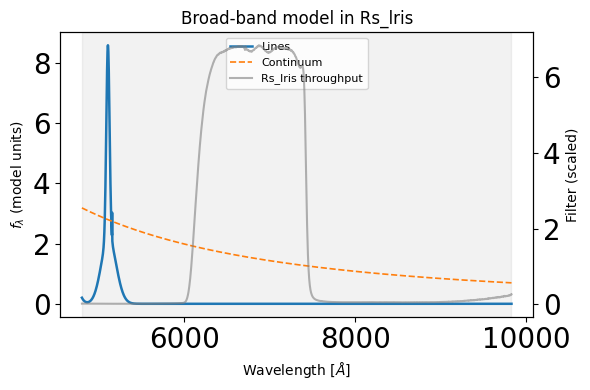

In [39]:
importlib.reload(line_fit)
filter_to_correct="Rs_lris"#"mosfire_Ks"#
filters={}
for match in [f"{filter_to_correct}"]:
    lam_f = curve[match][:,0]
    T_f = curve[match][:,1]
    filters[match]= (lam_f,T_f)

band_results = line_fit.compute_line_and_continuum_in_filters_powerlaw(
    q_mle,
    np.sort(lam_f),
    #q_mle.lam,
    filters,
    make_plots=True,
    #saveplot_path=path_out+"/line_in_filter.pdf",
    per_line_in_plot=True
)

for fname, res in band_results.items():
    print(
        f"{fname}: line_fraction = {res['line_fraction']:.3f}, "
        f"line_band = {res['line_band']:.3e}, cont_band = {res['cont_band']:.3e}"
    )
line_fit.save_band_results_powerlaw_csv(band_results,datapath+f"/line_corrections_{filter_to_correct}.csv")


## Optional sorting with MCMC

In [165]:
select="Ha_na"
from scipy import interpolate
line_ind=lines.index(select)
line_area=np.zeros(q.gauss_result_all.shape[0])
line_fwhm=np.zeros(q.gauss_result_all.shape[0])
line_center=np.zeros(q.gauss_result_all.shape[0])
for n_samp in range(q.gauss_result_all.shape[0]):
    f_lam=q.Onegauss(np.log(q.wave), q.gauss_result_all[n_samp,line_ind * 3:(line_ind + 1) * 3])
    fpeak = f_lam.max()
    #spline = interpolate.UnivariateSpline(q.wave, f_lam - fpeak / 2, s=0)
    line_area[n_samp]=np.trapz(f_lam,x=q.wave)
    ypeak_ind = np.argmax(f_lam)
    line_center[n_samp]=q.wave[ypeak_ind]
    #fwhm_left, fwhm_right = spline.roots().min(), spline.roots().max()
    #line_fwhm[n_samp]=np.abs(fwhm_left - fwhm_right) / line_center[n_samp] * ckm
#plt.plot(q.wave, q.Onegauss(np.log(q.wave), res_nsamp[line_ind * 3:(line_ind + 1) * 3]), color="red")
#plt.xlim([6500,6700])
#plt.axvline(6564.63)

In [ ]:
line'OIII5007c_1_centerwave_err'

## Save the MCMC chains

In [112]:
np.save(datapath+"/MUSE_gauss_result_abs_obj{}".format(obj),q.gauss_result_all)
np.save(datapath+"/MUSE_gauss_result_abs_wave_obj{}".format(obj),np.array([q.wave,q.line_flux,q.external_cont]))
np.save(datapath+"/MUSE_gauss_result_abs_sup_obj{}".format(obj),q.gauss_result_name)

In [268]:
gauss_all=np.load(datapath+"/MUSE_gauss_result_abs_obj{}.npy".format(obj))
wave_spec=np.load(datapath+"/MUSE_gauss_result_abs_wave_obj{}.npy".format(obj))
gauss_names=np.load(datapath+"/MUSE_gauss_result_abs_sup_obj{}.npy".format(obj))

In [25]:
pp=q_mle.gauss_result_name
ngauss = len(pp[:-q_mle.abs_ncomp]) // 3
pp_shaped = np.reshape(pp[:-q_mle.abs_ncomp], (ngauss, 3)) #excluding the absorber covering fractions Cf_n
pp_shaped_abs = pp_shaped[:q_mle.num_abs_line,:]
pp_shaped = pp_shaped[q_mle.num_abs_line:,:]
print(pp[-q_mle.abs_ncomp:])

            #q_mle.gauss_result_name[:-q_mle.ga]

['Cf_0' 'Cf_1']


In [31]:
ngauss

23

## making figure and save line properties: MCMC

In [1518]:
import pandas as pd
#print(q_mcmc.line_result_name)
#print('')
#print(q_mcmc.line_result)
q=q_mle
line_result=pd.DataFrame({"value":q.line_result},index=q.line_result_name)
print(line_result)
cont_result=pd.DataFrame({"value":q.conti_result},index=q.conti_result_name)

                                         value
1_complex_name                             CIV
1_line_status                                1
1_line_min_chi2              378.8103442801406
1_line_bic                  -1891.446001048563
1_line_red_chi2              0.260529810371486
1_niter                                    707
1_ndof                                    1454
CIV1548_br_1_scale           1.545670258451537
CIV1548_br_1_centerwave      7.338237660663882
CIV1548_br_1_sigma       4.357732594147509e-05
CIV1548_br_2_scale          0.9360240360578587
CIV1548_br_2_centerwave      7.354844712587861
CIV1548_br_2_sigma         0.01689975199003854
CIV1548_br_3_scale           5.359043764308069
CIV1548_br_3_centerwave      7.346734321373156
CIV1548_br_3_sigma       0.0026382706449684067
CIV1548_1_scale            0.06188882739621704
CIV1548_1_centerwave         7.343816091096674
CIV1548_1_sigma          0.0016453566711965473
CIV1550_1_scale              4.460557478935812
CIV1550_1_cen

In [1336]:
q.line_prop_from_name("Ha_br_1_sigma", 'narrow')

(0, 0, 0, 0, 0, 0)

In [1326]:
float(line_result.loc["Ha_br_1_sigma_err"][0])*2.355*3e5

41.07815972385977

In [1201]:
res=fits.open("/disk/bifrost/yuanze/KBSS/LyC22/MD90/jwst/LyC22-MD90_pyqsofit.fits")

In [1318]:
q.line_result_name

array(['1_complex_name', '1_line_status', '1_line_min_chi2', '1_line_bic',
       '1_line_red_chi2', '1_niter', '1_ndof', 'Ha_br_1_scale',
       'Ha_br_1_scale_err', 'Ha_br_1_centerwave',
       'Ha_br_1_centerwave_err', 'Ha_br_1_sigma', 'Ha_br_1_sigma_err',
       'NII6549_br_1_scale', 'NII6549_br_1_scale_err',
       'NII6549_br_1_centerwave', 'NII6549_br_1_centerwave_err',
       'NII6549_br_1_sigma', 'NII6549_br_1_sigma_err',
       'NII6585_br_1_scale', 'NII6585_br_1_scale_err',
       'NII6585_br_1_centerwave', 'NII6585_br_1_centerwave_err',
       'NII6585_br_1_sigma', 'NII6585_br_1_sigma_err', 'Ha_na_1_scale',
       'Ha_na_1_scale_err', 'Ha_na_1_centerwave',
       'Ha_na_1_centerwave_err', 'Ha_na_1_sigma', 'Ha_na_1_sigma_err',
       'NII6549_1_scale', 'NII6549_1_scale_err', 'NII6549_1_centerwave',
       'NII6549_1_centerwave_err', 'NII6549_1_sigma',
       'NII6549_1_sigma_err', 'NII6585_1_scale', 'NII6585_1_scale_err',
       'NII6585_1_centerwave', 'NII6585_1_centerwave_

['Ha_br', 'Ha_br', 'Ha_na', 'NII6549', 'NII6585']
KeyError: No such line exists in the par file
KeyError: No such line exists in the par file


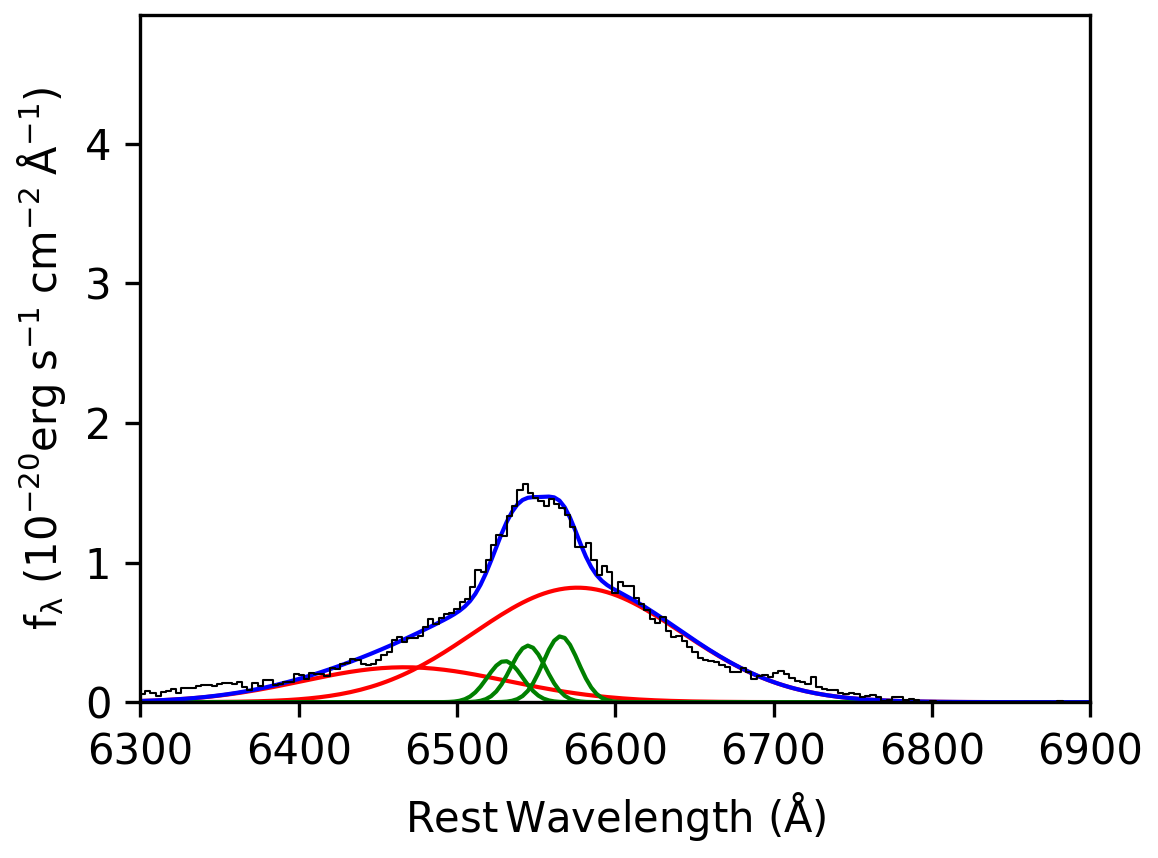

In [1294]:
plt.rcdefaults()
import scienceplots



fig, ax = plt.subplots(1, 1,figsize=(4,3), dpi=300)
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
q=q_mle

if q.MCMC:
    pname=q.gauss_result_name[::2]
    lines=['_'.join(pname[nn*3].split('_')[:-2]) for nn in range(int(len(pname) / 3))]
    print(lines)
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result

# Plot individual line components
if q.num_abs_line > 0:
    start_emission=q.num_abs_line
else:
    start_emission=0
for p in range(start_emission,int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

for p in range(start_emission):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model

ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
ax.step(q.wave, q.line_flux, 'k',lw=0.5)
xlow=6300
xhigh=6900
ax.set_xlim(xlow, xhigh)
yup=np.max(q.line_flux)
#yup=100
ylow=0
ax.set_ylim(ylow,yup)
#ax.set_yscale("log")
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-20} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)')
'''
Line properties
'''
#print("result for obj{}".format(obj))



#NII6549w_1_scale)      = -0.1871
#    C(Ha_br_2_scale, SII6718w_1
#all_area={}
#all_peaks={}
ln_to_print=['Lya_br','CIV1548_br']#,"CIV1548"]#,'CIII1908_br','OIII4959c','Ha_br','Ha_na','Hb_br','Hb_na',"NII6549","NII6585","SII6718","SII6732"]#,"NaI5890","NaI5896"]
#ln_to_print=['Ha_br']#,"NaI5890","NaI5896"]

text=['Lya','CIV1548_br','CIV1548',r'CIII]1908',r'[OIII]$\,$4959',r"H$\alpha_{Br}$",r"H$\alpha$",r"H$\beta$",r"[NII]$\,$6549",r"[NII]$\,$6585",r"[SII]$\,$6718",r"[SII]$\,$6732"]
with open(path_out+f'/{cubename}-{psname}.txt', 'w') as f:
        print("==============Line Fit Information from PyQSOFit=============",file=f)
        
for ind,ln in enumerate(ln_to_print):
    #try:
    if "br" in ln:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'broad')
    else:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'narrow')
#    except ValueError:
#        print("no detection of line", ln)
    #all_area[ln]=area
    #all_peaks[ln]=peak
    if q.MCMC:
        try:
            centerwave=np.exp(float(line_result.loc["{}_1_centerwave".format(ln)]))
            centerwave_err=float(line_result.loc["{}_2_centerwave_err".format(ln)])*centerwave
            sigma_err=float(line_result.loc["{}_1_sigma_err".format(ln)])*3e5
            fwhm_err=sigma_err*2.3548
            line_ind=lines.index(ln)
            line_area_samps=np.zeros(q.gauss_result_all.shape[0])
            for n_samp in range(q.gauss_result_all.shape[0]):
                f_lam=q.Onegauss(np.log(q.wave), q.gauss_result_all[n_samp,line_ind * 3:(line_ind + 1) * 3])
                line_area_samps[n_samp]=np.trapz(f_lam,x=q.wave)
            line_area=np.nanpercentile(line_area_samps,(16,84),axis=0)
        except KeyError:
            centerwave=0
            centerwave_err=0
            sigma_err=0
            fwhm_err=0
            line_area=[0,0]
            print("KeyError: No such line exists in the par file")
        #except ValueError:
         #   centerwave=0
         #   centerwave_err=0
        #    sigma_err=0
         #   fwhm_err=0
         #   line_area=[0,0]
         #   print("ValueError: No such line exists in the par file")
    else:
        centerwave=0
        centerwave_err=0
        sigma_err=0
        fwhm_err=0
        line_area=[0,0]
    with open(path_out+f'/{cubename}-{psname}.txt', 'a') as f:
        print("{}:".format(ln),file=f)
        print("FWHM (km/s)", np.round(fwhm, 4),np.round(fwhm_err, 4),file=f)
        print("Sigma (km/s)", np.round(sigma, 4), np.round(sigma_err, 4),file=f)
        print("EW (A)", np.round(ew, 1),file=f)
        print("Peak (A)", np.round(peak, 1),file=f)
        print("Center Wavelength of Gaussian Component (A)", np.round(centerwave, 1),np.round(centerwave_err, 1),file=f)
        print("Area (10^(-20) erg/s/cm^2)", np.round(area, 1),file=f)
        print("Area (lower, upper, from MCMC, 10^(-20) erg/s/cm^2)", np.round(line_area, 1),file=f)
        print("",file=f)
    
    if peak > xhigh or peak < xlow:
        continue
    ax.axvline(peak,color="C{}".format(ind),lw=0.5,ls=":")
    try:
        ax.text(peak*0.999, 5e-1*yup,text[ind], rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
    except:
        print(ln,"doesn't have a text label!")
if q.MCMC:
    with open(path_out+f'/{cubename}-{psname}.txt', 'a') as f:
        print(cont_result.loc["L5100"],cont_result.loc["L5100_err"],file=f)
#ax.plot(lam/(1+redshift),continterp*1e-3,"r")
#ax.plot(lam/(1+redshift),flux,"m")
#ax.ylim()
#ax.plot(lam/(1+z),err,"k")
#ax.axvline(5890)
ax.axvline(5896)
ax.axvline(5876)
plt.tight_layout()
fig.savefig(path_out+f"/{instru}_1D_pyqsofit.pdf")

In [1248]:
q.gauss_result_all[1][2::3]

array([0.01608896, 0.0029659 , 0.00058386, 0.00053765, 0.00053765,
       0.00164164, 0.00169   ])

In [1255]:
np.percentile(fwhms,50)

3614.285099078642

In [1251]:
fwhms=[]
for i in range(q.gauss_result_all.shape[0]):
    fwhms.append(q.line_prop(1550,q.gauss_result_all[i], 'broad')[0])

In [1258]:
np.percentile(fwhms,(32,68))-np.percentile(fwhms,50)

array([-294.67620833,  352.69264067])

In [ ]:
for n_samp in range(q.gauss_result_all.shape[0]):
    f_lam=q.Onegauss(np.log(q.wave), q.gauss_result_all[n_samp,line_ind * 3:(line_ind + 1) * 3])
    line_area_samps[n_samp]=np.trapz(f_lam,x=q.wave*(1+redshift))
np.nanpercentile(line_area_samps,(16,84),axis=0)

In [1256]:
q.line_prop_from_name(ln, 'broad')

(3485.6394875734245,
 4582.042915519141,
 82.76995054577337,
 1551.0052247729395,
 4910.245812368656,
 2.846862406602787)

In [329]:
def search_pattern_in_array(arr, pattern="Cf"):
    """
    Searches for a given pattern in a NumPy array of strings.
    
    Parameters:
    arr (np.ndarray): NumPy array of strings to search within.
    pattern (str): Pattern to search for in each string.
    
    Returns:
    np.ndarray: Array of strings containing the pattern.
    """
    # Use np.char.find to get indices where the pattern is found
    match_indices = np.char.find(arr, pattern) >= 0  # Boolean mask
    return arr[match_indices]

# Example usage
matching_strings = search_pattern_in_array(q.line_result_name)
print(matching_strings)

[]


In [105]:
q.line_result_name.shape

(159,)

## Generating EW for NaID

In [383]:
linename="NaI5896"

ind_ini=np.where(q.gauss_result_name=="NaI5890_1_scale")[0][0]

param=q.gauss_result[ind_ini:ind_ini+3]
#linec=np.exp(float(line_result.loc["{}_1_centerwave".format(linename)]))

out_conti=np.interp(q.wave,contwave,cont)
f_lam=q.Onegauss(np.log(q.wave), param)+out_conti*1e-3


line_area=np.trapz(f_lam[abs_ind],x=q.wave[abs_ind])

EW=line_area/np.trapz(out_conti[abs_ind]*1e-3,x=q.wave[abs_ind])

In [384]:
line_reg_ind=np.where(q.gauss_result_name=="NaI5890_1_scale")[0]

0.9847517734162845

In [439]:
q.num_abs_line

2

In [381]:
abs_ind=abs_f<-1e-2

In [372]:
np.exp(8.68107932)

5890.400788992586

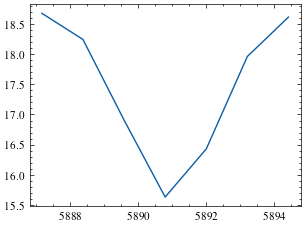

In [382]:
plt.plot(q.wave[abs_ind],f_lam[abs_ind])

In [128]:
from astropy.cosmology import Planck18
SA=Planck18.luminosity_distance(0.0312).to(u.cm)**2*4*np.pi
0.95*np.log10(457.6e-17*SA.value)+3.89

41.92798420679962

In [336]:
q.gauss_result

array([ 1.02319557e+02,  8.78937940e+00,  4.95438291e-04,  1.79535953e+01,
        8.78712777e+00,  4.95438291e-04,  4.83493595e+01,  8.79252271e+00,
        4.95438291e-04,  1.80016418e+01,  8.81251935e+00,  4.95438291e-04,
        1.38378947e+01,  8.81465749e+00,  4.95438291e-04,  6.51179000e+00,
        8.67849759e+00,  4.95438291e-04, -2.95371437e+00,  8.68107932e+00,
        2.20810874e-04, -6.57672882e-02,  8.68209308e+00,  2.20810874e-04,
        5.63811839e+02,  8.78952544e+00,  2.20810874e-04,  6.42606079e+01,
        8.78727382e+00,  2.20810874e-04,  1.97361892e+02,  8.79266875e+00,
        2.20810874e-04,  6.52320092e+01,  8.81266539e+00,  2.20810874e-04,
        5.43268636e+01,  8.81480353e+00,  2.20810874e-04,  4.38539371e+01,
        8.48927621e+00,  4.95438291e-04,  1.19506756e+02,  8.48942225e+00,
        2.20810874e-04,  3.68401698e+00,  8.50915174e+00,  4.95438291e-04,
        1.29129030e+01,  8.51877050e+00,  4.95438291e-04,  3.87224475e+00,
        8.50929778e+00,  

In [98]:
from dust_attenuation.averages import C00
Cex=C00()

In [54]:
all_area

{'OIII5007w': 80.58972657969765,
 'OIII4959w': 21.789950861216155,
 'Ha_naw': 2144.5587838064025,
 'Hb_naw': 230.54526591454626,
 'NII6549w': 445.65694688327255,
 'NII6585w': 1428.182661955051,
 'SII6718w': 162.3768680690234,
 'SII6732w': 213.94720511305445}

In [182]:
#print(r"H$_2$/Br$\gamma$",all_area['H2_10_S1']/all_area['Brg_na'])
#print("H_2/Br gamma",all_area['H2_10_S1']/all_area['Brg_na'])
#EBV=2.5/1.163*np.log10(((all_area['Ha_naw']+all_area['Ha_na'])/(all_area['Hb_naw']+all_area['Hb_na'])/2.68))
EBV=2.5/(Cex.k_lambda(x=[0.486268])-Cex.k_lambda(x=[0.656461]))*np.log10(((all_area['Ha_naw']+all_area['Ha_na'])/(all_area['Hb_naw']+all_area['Hb_na'])/2.86))

print(EBV)

[0.46206538]


In [183]:
from dust_attenuation.averages import C00
Cex=C00()
wave=[]
for key in all_peaks:
    if all_peaks[key]/10000 > 2.2:
        continue
    else:
        wave.append(all_peaks[key]/10000)
Alambda=Cex.k_lambda(x=wave)*EBV
print(Cex.k_lambda(x=[0.5500])*EBV)

[1.87039001]


In [184]:
print(Cex.k_lambda(x=[0.5500])*0.69)

[2.79304436]


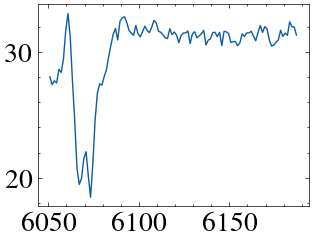

In [90]:
xlow=5867
xhigh=6000
line_ind=(lam/(1+z)>xlow)&(lam/(1+z)<xhigh)

plt.plot(lam[line_ind],data[:,1][line_ind]*1e-3)

In [387]:
# Requried
data = np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))
lam = data[:,0]  # OBS wavelength [A]
#flux = data[:,1]*1e-3  # OBS flux [1e-17 erg/s/cm^2/A]
err = data[:,2]*1e-3  # 1 sigma error

#continuum
cont=np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_ppxfmodel_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))*1e20 # to 1e-20
contwave=np.loadtxt(os.path.join(path_out, "wave_ln_binned.txt"))
continterp=np.interp(lam,contwave,cont)
flux=(data[:,1]-continterp)*1e-3




# create FITS file containing fitting parameter setup 
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

line_priors = np.rec.array([
    (5889.950, 'Ha', 2800, 6800, 'NaI5890w', 1, 1e1, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 5, 5, 0, 0.001, 1),
    (5895.924, 'Ha', 2800, 6800, 'NaI5896w', 1, 1e1, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 5, 5, 0, 0.001, 1),
    #(6564.61, 'Ha', 2800, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6549.85, 'Ha', 6400, 6800, 'NII6549_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6585.28, 'Ha', 6400, 6800, 'NII6585_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 2800, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 2800, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (6585.28, 'Ha', 2800, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.003, 1),
    (6718.29, 'Ha', 2800, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (6732.67, 'Ha', 2800, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (5875.621, 'Ha', 2800, 6800, 'HeI5876', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    
    

    
#    (8498.02, 'Ha', 6400, 6800, 'CaII8498', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
#    (8542.09, 'Ha', 6400, 6800, 'CaII8542', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
#    (8662.14, 'Ha', 6400, 6800, 'CaII8662', 1, 0.0,  -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
    
    (6564.61, 'Ha', 2800, 6800, 'Ha_naw',  1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7,  0.00169, 0.01, 3, 3, 0, 0.002, 1),
    (6549.85, 'Ha', 2800, 6800, 'NII6549w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.001, 1),
    (6585.28, 'Ha', 2800, 6800, 'NII6585w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.003, 1),
    (6718.29, 'Ha', 2800, 6800, 'SII6718w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.001, 1),
    (6732.67, 'Ha', 2800, 6800, 'SII6732w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.001, 1),

    #(4862.68, 'Ha', 2800, 6800, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Ha', 2800, 6800, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169,     0.01, 1, 1, 0, 0.002, 1),
    (4862.68, 'Ha', 2800, 6800, 'Hb_naw', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169,    0.01, 3, 3, 0, 0.002, 1),
    (4960.30, 'Ha', 2800, 6800, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Ha', 2800, 6800, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Ha', 2800, 6800, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, 0.01, 3, 3, 0, 0.001, 1),
    (5008.24, 'Ha', 2800, 6800, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, 0.01, 3, 3, 0, 0.002, 1)
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 2800.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    (19700.,20250.),
    (21700.,22250.)
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  0), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  0), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  0), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000,20000,20900]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar_obj{}_{}_abs.fits'.format(obj,instru)), overwrite=True)